## Problem Statement:
Yulu, India’s leading micro-mobility service provider, has experienced a noticeable decline in revenue and seeks to understand the key factors influencing the demand for its shared electric cycles. The objective is to identify the most significant variables—such as season, weather, weekdays and holidays that affects the user demand. This analysis aims to build a predictive model to estimate demand patterns and guide data-driven business strategies for growth.

In [16]:
# Importing required libraries -
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind # T-test for independent samples
from scipy.stats import shapiro # Shapiro-Wilk’s test for Normality
from scipy.stats import levene # Levene's test for Equality of Variance
from scipy.stats import f_oneway # One-way ANOVA
from scipy.stats import chi2_contingency # Chi-square test of independence
# from scipy.stats import kstest # KS test for Normality

Import the Dataset:

In [2]:
df = pd.read_csv('/content/Yulu dataset.txt')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# shape of the Dataset:
df.shape

(10886, 12)

In [4]:
# general info(dtypes, non-null count) about the Dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [9]:
# Null value percentage of the Dataset:
(df.isna().sum()/len(df))*100

,0
datetime,0.0
season,0.0
holiday,0.0
workingday,0.0
weather,0.0
temp,0.0
atemp,0.0
humidity,0.0
windspeed,0.0
casual,0.0


In [10]:
# Check for Duplicates :
duplicates = df[df.duplicated()]
duplicates

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


There is no Duplicates in the dataset.

In [14]:
# value counts of columns:
col = ['season',	'holiday',	'workingday',	'weather']
for i in col:
  print('column_name: ', i),
  print('Value counts: '),
  print(df[i].value_counts())
  print()



column_name:  season
Value counts: 
season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

column_name:  holiday
Value counts: 
holiday
0    10575
1      311
Name: count, dtype: int64

column_name:  workingday
Value counts: 
workingday
1    7412
0    3474
Name: count, dtype: int64

column_name:  weather
Value counts: 
weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64



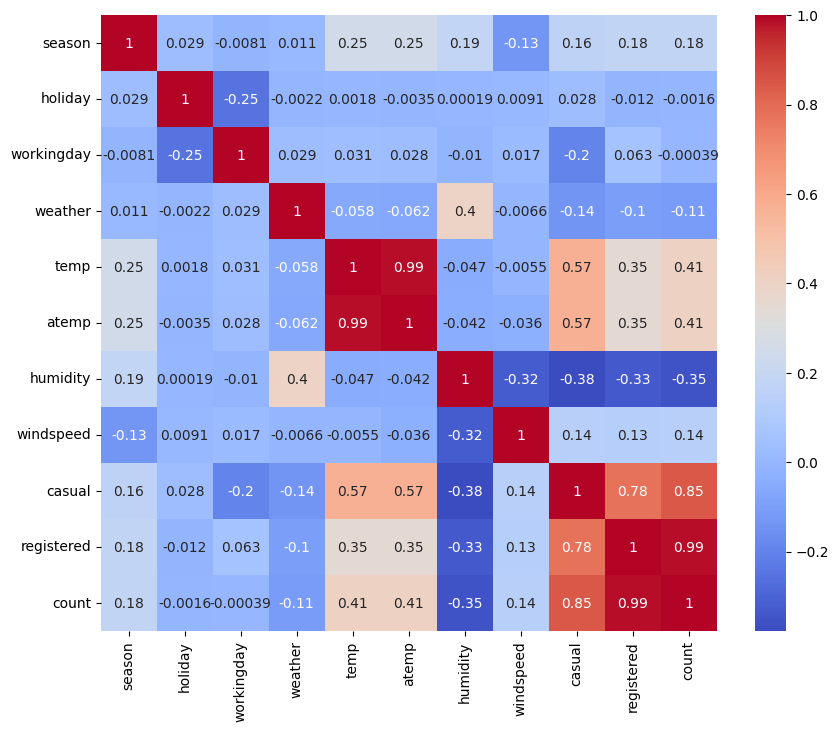

In [19]:
# we will check the correlation between the columns
df_cor = df[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed',	'casual',	'registered',	'count']]
plt.figure(figsize=(10,8))
sns.heatmap(df_cor.corr(method='spearman'),annot=True,square=True, cmap='coolwarm')
plt.show()


from the heatmap,
* We found that the casual, registered and count columns are highly correlated since casual and registerd total is count.  
* Columns temp and atemp is also highly correlated  


In [20]:
# we will drop the datetime column and we will also remove the columns which are highly correlated such as atemp, casual, registered
df.drop(columns=['datetime','atemp', 'casual', 'registered'],axis=1,inplace=True)
df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,1,0,0,1,9.84,81,0.0,16
1,1,0,0,1,9.02,80,0.0,40
2,1,0,0,1,9.02,80,0.0,32
3,1,0,0,1,9.84,75,0.0,13
4,1,0,0,1,9.84,75,0.0,1


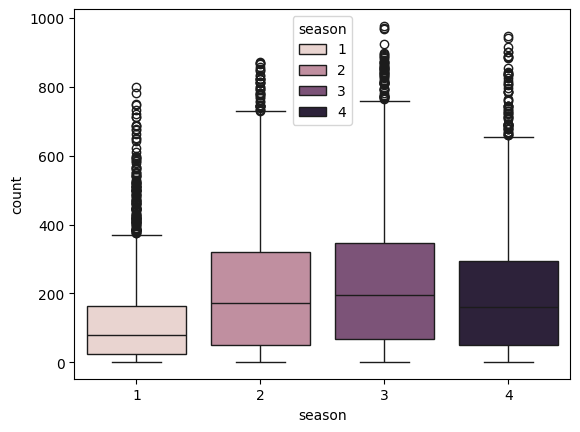

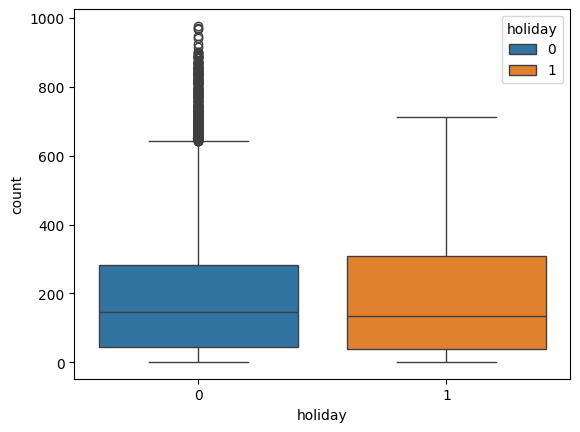

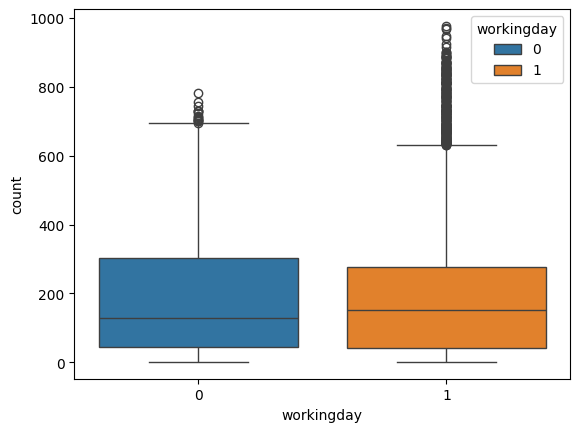

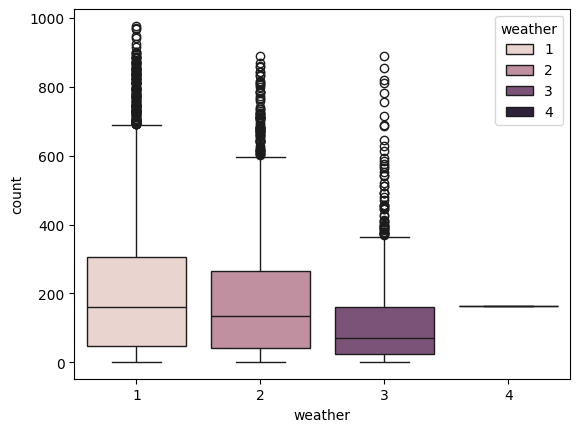

In [21]:
# Outliers detection using boxplots :
col_list=['season',	'holiday',	'workingday',	'weather']
for i in col_list:
  sns.boxplot(y=df['count'],x=df[i],hue=df[i])
  plt.show()

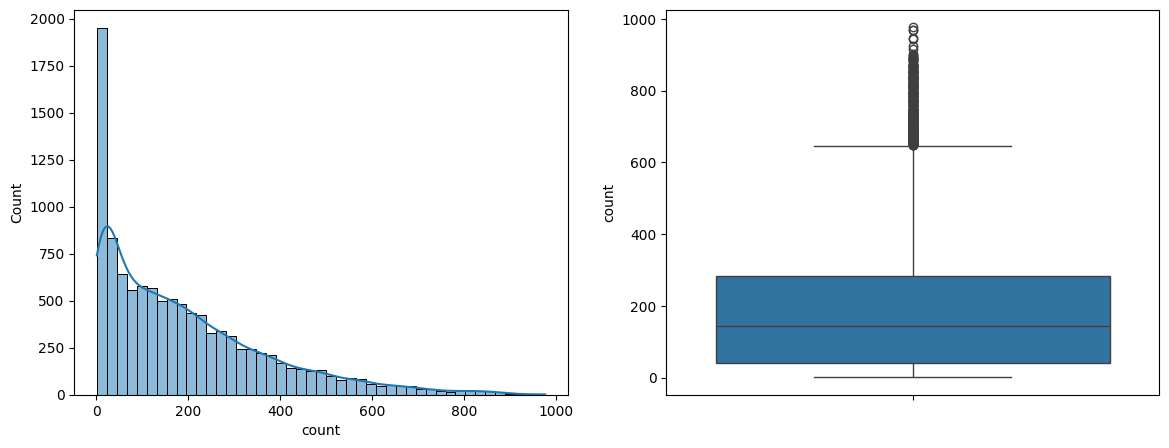

In [34]:
# Checking the Distribution and Outliers of Count column
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df['count'],kde=True) # Histogram

plt.subplot(1,2,2)
sns.boxplot(df['count']) # Boxplot
plt.show()

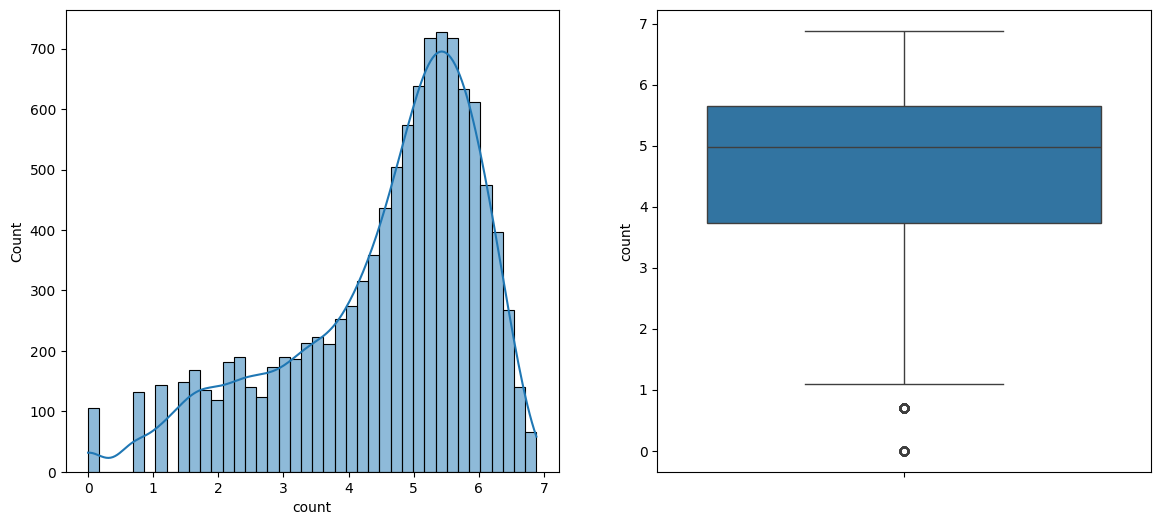

In [38]:
# we can use log transformation to standardize the value and then check the distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(np.log(df['count']),kde=True)

plt.subplot(1,2,2)
sns.boxplot(np.log(df['count']))
plt.show()

From the boxplot, we can confirm that we have lot of outliers in the dataset.  Since there is only 10,886 rows and these outliers in the count column is
due to higher transaction on a specific day or during season or weather.  Removing these outliers will impact on the originality of the data hence we will keep it.  
### If we need to remove them we can use the IQR method as mentioned below

In [24]:
q1 = df['count'].quantile(0.25)
q3 = df['count'].quantile(0.75)
IQR = (q3-q1)
df_iqr = df[~((df['count'] < (q1-(IQR*1.5)))| (df['count']>(q3 + (IQR*1.5))))]
df_iqr # Dataframe after removing outliers.


,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,1,0,0,1,9.84,81,0.0000,16
1,1,0,0,1,9.02,80,0.0000,40
2,1,0,0,1,9.02,80,0.0000,32
3,1,0,0,1,9.84,75,0.0000,13
4,1,0,0,1,9.84,75,0.0000,1
...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,50,26.0027,336
10882,4,0,1,1,14.76,57,15.0013,241
10883,4,0,1,1,13.94,61,15.0013,168
10884,4,0,1,1,13.94,61,6.0032,129


Number of rows removed due to Outliers:  

In [25]:
df.shape[0]-df_iqr.shape[0]

300

Aggregating total number of bike riders as per season, holiday, workingday, weather


In [39]:
#season
df.groupby('season')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


In [40]:
# holiday
df.groupby('holiday')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
holiday,,,,,,,,
0,10575.0,191.741655,181.513131,1.0,43.0,145.0,283.0,977.0
1,311.0,185.877814,168.300531,1.0,38.5,133.0,308.0,712.0


In [41]:
# workingday
df.groupby('workingday')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


In [42]:
# weather
df.groupby('weather')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,205.236791,187.959566,1.0,48.0,161.0,305.0,977.0
2,2834.0,178.955540,168.366413,1.0,41.0,134.0,264.0,890.0
3,859.0,118.846333,138.581297,1.0,23.0,71.0,161.0,891.0
4,1.0,164.000000,NaN,164.0,164.0,164.0,164.0,164.0


## Is there a significant difference in the number of bike rides between weekdays and weekends
HO : The demand of bikes on weekdays is higher than or equal to demand on weekends
Ha : The demand of bikes on weekdays is lesser than demand on weekends

HO : u1 >= u2

Ha : u1 < u2

where u1 = bike rides on weekdays and u2 = bike rides on weekends

### Which test to use, Z-test or T-test ?
since population standard deviation is not known we will use the T-test

In [53]:
weekday = df[df['workingday']==1]['count'].sample(3400)
weekend = df[df['workingday']==0]['count'].sample(3400)

Sampling was taken as 3400 since the number of weekend entries in the dataset is around 3400 and we don't want to unequal samples size since it leads to unequal variances between samples.  This affects the assumption of test like T-test or ANOVA

Unequal sampling will increase the variance which affects the statistical power of a test

In [57]:
# lets find the standard deviation of both weekday and weekend data:
print(f"The sample standard Deviation of the bike rides on weekday: ",np.std(weekday)),
print(f"The sample standard Deviation of the bike rides on weekend: ",np.std(weekend))

The sample standard Deviation of the bike rides on weekday:  187.81585870742333
The sample standard Deviation of the bike rides on weekend:  173.71451202145172


Since both the sample standard deviation are different we can assume that the  population standard deviation are also different.  We will use a one tail two sample T-test for this  

In [58]:
tstat,pval= ttest_ind(weekday,weekend,alternative='less')
tstat,pval

(np.float64(1.6092700503518873), np.float64(0.9461981310267359))

In [59]:
# Lets set the significance level to 0.05
alpha=0.05
if pval < alpha:
  print(f"reject the Null Hypothesis, Demand for bikes on weekdays is lesser than demand for bikes on weekends")
else:
  print(f"Fail to reject the Null Hypothesis, Demand for bikes on weekdays is greater or similar to the demand on Weekends")

Fail to reject the Null Hypothesis, Demand for bikes on weekdays is greater or similar to the demand on Weekends


### Observations:
Since Pval is greater than alpha(0.05) we fail to reject the Null Hypothesis.  We have enough evidence to prove that the Demand of bikes on weekdays is greater or similar to those on Weekends.

## Is there a significant difference in the number of bike rides between regular days and Holidays
HO : The demand of bikes on regular days is higher than or equal to demand on Holidays

Ha : The demand of bikes on regular days is lesser than demand on Holidays

HO : u1 >= u2

Ha : u1 < u2

where u1 = bike rides on regular days and u2 = bike rides on holidays

In [61]:
df['holiday'].value_counts()

,count
holiday,
0,10575
1,311


In [62]:
holiday = df[df['holiday']==1]['count'].sample(300)
regularday = df[df['holiday']==0]['count'].sample(300)

We use sample size of 300 since holiday has around 311 entries in the dataset.  

We don't want any inequality in sampling between them which increases the variance and this affects the statistical power of Test.

In [64]:
print(f"sample standard deviation of holiday: ",np.std(holiday))
print(f"sample standard deviation of regularday: ",np.std(regularday))

sample standard deviation of holiday:  169.2065999172478
sample standard deviation of regularday:  194.31292228430578


## What test to use ?
### Since Population standard deviation is unknown hence we will use T-test

Sample standard deviation between holiday and regularday is different hence population standard deviation is also assumed to be different.  This is onetail test concerning two independent population hence 2 sample T-test would be the perfect for this

In [67]:
tstat,pval = ttest_ind(regularday,holiday,equal_var=False,alternative='less')
tstat,pval

(np.float64(0.8191937434367549), np.float64(0.7934958003033501))

In [68]:
# Lets set the significance level to 0.05
alpha=0.05
if pval < alpha:
  print(f"reject the Null Hypothesis")
else:
  print(f"Fail to reject the Null Hypothesis")

Fail to reject the Null Hypothesis


## Observations:
Since p_value is greater than the significance level of 0.05. We Fail to reject the Null Hypothesis.  We have evidence to prove that demand of bike rides on regular day is higher than or similar to demands on holidays .

## Is the demand of Bike rides is same on all Weather conditions

HO : The Average number of bikes in different Weather conditions are same.

Ha : The Average number of bikes in different Weather conditions are not same.

HO : u1 >= u2

Ha : u1 < u2

where u1 = bike rides on regular days and u2 = bike rides on holidays

In [69]:
df['weather'].value_counts()

,count
weather,
1,7192
2,2834
3,859
4,1


In [70]:
df = df[~(df['weather']==4)]

In [71]:
w1 = df[df['weather']==1]['count'].sample(850)
w2 = df[df['weather']==2]['count'].sample(850)
w3 = df[df['weather']==3]['count'].sample(850)

**ANOVA** should be the right test for this provided that the Assumptions are met.
### Assumptions of ANOVA
* Sample should be random and independent
* Variance between the groups should be equal
* Each sample should follow a Normal Distribution

These assumptions can be checked, for normality we can use Shapiro-Wilk's test and for variance check we can use Levene test.  If Assumptions are not met then we can use Kruskal-Wallis test.

### Shapiro Test:
We will use Shapiro test to check the Normality

HO : Count follows a Normal Distribution

Ha : Count doesn't follow a Normal Distribution

In [74]:
statistics,pval = shapiro(df['count'].sample(5000))
print(f"P_val is: {pval}")

P_val is: 3.078834712296397e-53


Since Pval is lesser than alpha 0.05 we reject the Null Hypothesis that the count follows a Normal Distribution

We will use Levene Test to check the euqality in Variance

HO : All the count variance are equal

Ha : All the count variance are different from the rest

In [75]:
statistics,p_val = levene(w1,w2,w3)
print(f"P_values : {p_val}")

P_values : 1.0491068663482744e-20


since Pvalue is less than alpha 0.05, we reject the Null Hypothesis that the count variances are equal.

## Central Limit Theorem:
* we have learned that, According to CLT if the sample size is larger the sample distribution will follow a normal distribution even the original distribution is not normal.  
* when we take sample range of 30 and above this would be enough to hold CLT

Hence when the sample size is larger we don't have to worry about the non-normality of distribution in the dataset before applying these test.



We can use other tests to check the normality of the distribution:


In [80]:
# plot the distribution of sample
sample_50 = df['count'].sample(50).values
sample=[]
for i in range(5000):
  sample_mean = np.mean(df['count'].sample(50).values)
  sample.append(round(sample_mean,0))
sample

[np.float64(121.0),
 np.float64(200.0),
 np.float64(208.0),
 np.float64(201.0),
 np.float64(172.0),
 np.float64(219.0),
 np.float64(205.0),
 np.float64(171.0),
 np.float64(208.0),
 np.float64(171.0),
 np.float64(158.0),
 np.float64(168.0),
 np.float64(176.0),
 np.float64(178.0),
 np.float64(181.0),
 np.float64(219.0),
 np.float64(201.0),
 np.float64(176.0),
 np.float64(159.0),
 np.float64(186.0),
 np.float64(202.0),
 np.float64(220.0),
 np.float64(199.0),
 np.float64(183.0),
 np.float64(184.0),
 np.float64(192.0),
 np.float64(240.0),
 np.float64(170.0),
 np.float64(197.0),
 np.float64(253.0),
 np.float64(156.0),
 np.float64(256.0),
 np.float64(245.0),
 np.float64(216.0),
 np.float64(227.0),
 np.float64(188.0),
 np.float64(215.0),
 np.float64(221.0),
 np.float64(184.0),
 np.float64(222.0),
 np.float64(182.0),
 np.float64(165.0),
 np.float64(216.0),
 np.float64(209.0),
 np.float64(199.0),
 np.float64(206.0),
 np.float64(201.0),
 np.float64(188.0),
 np.float64(202.0),
 np.float64(176.0),


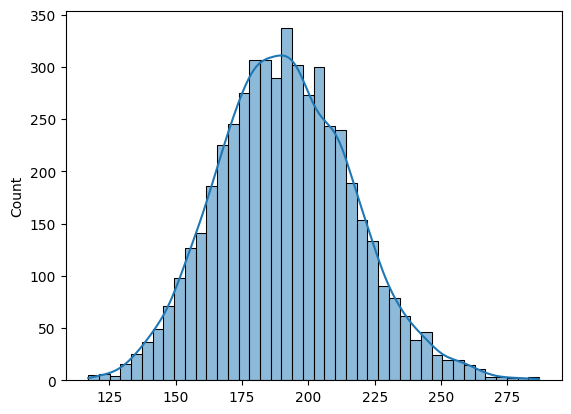

In [82]:
sns.histplot(sample,kde=True)
plt.show()

Sample mean distribution follows Normal distribution

In [89]:
# we can check with the qqplot to check the distribution:
from statsmodels.graphics.gofplots import qqplot
df_qq = pd.DataFrame(sample, columns=['sample_mean'])
df_qq

,sample_mean
0,121.0
1,200.0
2,208.0
3,201.0
4,172.0
...,...
4995,229.0
4996,217.0
4997,169.0
4998,172.0


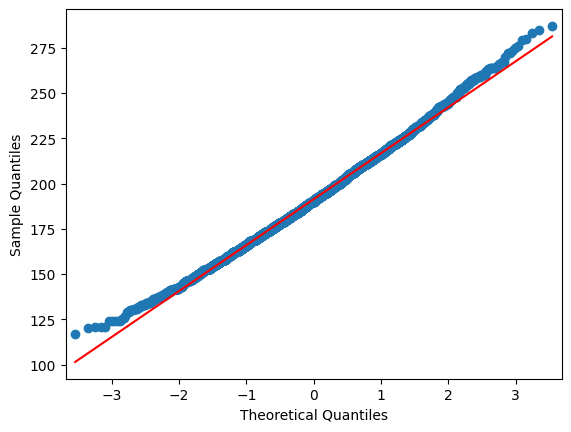

In [92]:
qqplot(df_qq['sample_mean'],line='s')
plt.show()

Even with QQplot its evident that sample mean distribution follows normal distribution

In [95]:
# Method 3: Check skewness & kurtosis
# Skewness should be close to 0 and Kurtosis close to 3.
print(f"Skewness: {df['count'].skew()}")
print(f"Kurtosis: {df['count'].kurt()}")

Skewness: 1.2419715082388256
Kurtosis: 1.2996467347537868


but, when we check the count data column distribution is positive skewed data(right skewed) and Kurtosis platykurtic, indicating lighter tails and a flatter peak compared to a normal distribution.

In [96]:
# To check the homogeneity of Variance:
print(w1.var(),w2.var(),w3.var())

35041.36424028272 31660.335050232126 19320.63649275965


### Lets set the significance level to 0.05

### Calculate Pvalue using One Way ANOVA,

In [97]:
fstat,pval = f_oneway(w1,w2,w3)
fstat,pval

(np.float64(63.71305009922087), np.float64(9.992860219175176e-28))

In [98]:
alpha=0.05
if pval < alpha:
  print(f"Reject the Null Hypothesis")
else:
  print(f"Fail to reject the Null Hypothesis")


Reject the Null Hypothesis


## Observations:
Since P_Value is less than the significance level of 0.05 we reject the Null Hypothesis.  We have statistical evidence that the Average Bikes rides are different for different Weather conditions.

If incase assumptions don't meet then go for Kruskal test

In [100]:
from scipy.stats import kruskal
kruskal(w1,w2,w3)

KruskalResult(statistic=np.float64(130.76583717799133), pvalue=np.float64(4.023085348303232e-29))

P_value is less than significance level of 0.05, hence reject the null hypothesis.  we have statistical evidence that the Avg bike rides for different weather conditions are not equal

---
### We know that avg rides are different for different seasons, lets find on which season is the highest and which is the lowest?
---
* we will use 2sample T-test for this - (w1-Sunny, w2-Cloudy, w3-Rainy)

First we will compare,
w1(sunny) vs w2(cloudy)

In [117]:
ttest_ind(w1,w2, equal_var=False, alternative='greater')

TtestResult(statistic=np.float64(2.3765874028290916), pvalue=np.float64(0.008792101934939267), df=np.float64(1693.6484166669454))

w2(cloudy) vs w3(rainy)

In [118]:
ttest_ind(w2,w3,equal_var=False, alternative='greater')

TtestResult(statistic=np.float64(8.738473247101593), pvalue=np.float64(2.9176388047547108e-18), df=np.float64(1604.0266997519952))

w1(sunny) vs w3(rainy)

In [119]:
ttest_ind(w1,w3,equal_var=False, alternative='greater')

TtestResult(statistic=np.float64(11.094905072690514), pvalue=np.float64(6.863126603432108e-28), df=np.float64(1566.9576457274889))

### Observations:
We can conclude that bike rides are higher on Sunny days followed by cloudy days and low on Rainy days

## Is demand for Bike cycles on rent is same for different Seasons

Lets do the Hypothesis Testing

HO: Demand for Bike cycles on rent for different Seasons are same

Ha: Demand for Bike cycles on rent for different Seasons are not equal



In [101]:
df.groupby('season')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2685.0,116.325512,125.293931,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


In [103]:
s1 = df[df['season']==1]['count'].sample(2600)
s2 = df[df['season']==2]['count'].sample(2600)
s3 = df[df['season']==3]['count'].sample(2600)
s4 = df[df['season']==4]['count'].sample(2600)

We take sample of 2600 hence there is no inequality in sampling between the 4 seasons which will affect the statistical power of test.

Lets calculate the Pvalue with significance level of 0.05 :

In [105]:
test_stat,pval = f_oneway(s1,s2,s3,s4)
pval

np.float64(4.385070143341556e-143)

In [106]:
alpha = 0.05
if pval < alpha:
  print(f"reject the null hypothesis")
else:
  print(f"fail to reject the null hypothesis")

reject the null hypothesis


## Observations:
Since Pvalue is less than the Significance level of 0.05 we reject the Null Hypothesis.  We have significant evidence that the demand for bike rides on different seasons are not same

---
## Is there an Interaction effect between the season and weather conditions on the count of Bike cycles rides ?
---
we can use 2way ANOVA for this, first we will replace the numbers with season and weather names

In [107]:
dict1 = {1: 'Sunny',
         2: 'Cloudy',
         3: 'Rainy'}
dict2 = {1: 'Summer',
         2: 'Monsoon',
         3: 'Winter',
         4: 'Autumn'}

In [108]:
df['weather_name'] = df['weather'].map(dict1)
df['season_name'] = df['season'].map(dict2)

In [111]:
!pip install pingouin
import pingouin as pg

In [112]:
pg.anova(dv='count',between=['weather_name','season_name'],data=df)

,Source,SS,DF,MS,F,p-unc,np2
0,weather_name,6.022043e+06,2.0,3.011022e+06,99.604322,1.361093e-43,0.017992
1,season_name,2.158708e+07,3.0,7.195692e+06,238.032851,1.350921e-149,0.061629
2,weather_name * season_name,5.588352e+05,6.0,9.313920e+04,3.081036,5.150817e-03,0.001697
3,Residual,3.286889e+08,10873.0,3.022983e+04,NaN,NaN,NaN


## Observations:
Since Pvalues are all less than the significance level of 0.05, we have enough evidence to prove that there is a significant interaction between the seasons and the weather on the avg bike rides

There is also another observation that avg rides are not equal for different seasons and for different weather which **we have already proved using one way ANOVA**

---
### We can also check, wheather there is weather conditions significantly differs for different seasons ?
---
We can do this using Chisquare contingency table, lets confirm Null and Alternate Hypothesis,

HO: Weather conditions are independent on seasons

Ha: Weather conditions are dependent on the ongoing seasons

In [114]:
contingency_table = pd.crosstab(df['season_name'],df['weather_name'])
contingency_table

weather_name,Cloudy,Rainy,Sunny
season_name,,,
Autumn,807,225,1702
Monsoon,708,224,1801
Summer,715,211,1759
Winter,604,199,1930


<Axes: xlabel='season_name'>

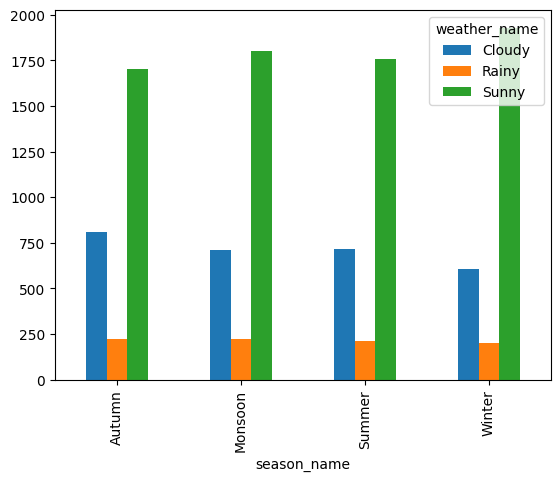

In [115]:
contingency_table.plot(kind='bar')

In [ ]:
chi2_contingency(contingency_table)

In [116]:
chi2_contingency(contingency_table)

Chi2ContingencyResult(statistic=np.float64(46.10145731073249), pvalue=np.float64(2.8260014509929343e-08), dof=6, expected_freq=array([[ 711.81956821,  215.75617823, 1806.42425356],
       [ 711.55920992,  215.67726229, 1805.76352779],
       [ 699.06201194,  211.8892972 , 1774.04869086],
       [ 711.55920992,  215.67726229, 1805.76352779]]))

## Observations:
Pvalue(2.8260014509929343e-08) is less than the significance level of 0.05 hence we reject the null hypothesis.  We have evidence that the Weather conditions depends on the ongoing seasons

## Insights and Recommendations:
#### **EDA based insights -**
* Total 10,886 rows were present in the data set.
* Dataset didn't have any missing values or duplicate values.
* temp and atemp columns are highly correleated hence we dropped one column 'atemp'
* 'casual' and 'register' columns total is equal to 'count' column hence they are highly correleated. Hence we dropped 'casual' and 'registered' columns.
* Outliers were found in the count column but we didn't remove it since we want to keep the originality of the dataset.

### **Insights from Hypothesis Testing**
* The demand for bikes on weekdays are higher than demand on weekends.
* The demand for bikes on regular days was higher than demand on holidays.
* The demand for bike rides for different seasons are not the same.
* Demand is higher on the Sunny days followed by Cloudy days and low on Rainy days.
* The demand for bike rides for different weather are not the same.
* There is a significant interaction between the seasons and the weather on the avg bike rides
* We have also proved that Weather conditions and seasons are dependent.

### **Recommendations for Yulu**
* Ensure high availability on weekdays, especially on office hours
* Optimize bike redistribution at high traffic locations such as metro, bus stand, offices etc
* Launch weekends and holidays packages to boost weekends and holidays sales
* bike rides are less on rainy seasons hence we can launch discount prices on the rainy seasons and offer accessories(rain coats, mobile cover) for riders
* partner with cafe, parks and event venues for launching ride and rewards program and promotions
* Introduce loyalty programms for daily users
* reward frequent users with cashbacks
* lauch referal program to increase the logins/new customers
* we can build model to show real time demand/ weather based suggestions in the App
